# 🔥 Interpreting Qwen2.5-VL Object Hallucination

In [1]:
import os
os.chdir("../")

In [182]:
# Set the huggingface mirror and cache path
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com" # for Chinese
os.environ["HF_HOME"] = "./model_checkpoint/hf_cache"


from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

import torch
from torch import nn
import torchvision.transforms.functional as TF

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import metrics
import textwrap
from tqdm import tqdm

from interpretation.submodular_vision import MLLMSubModularExplanationVision

from utils import SubRegionDivision
from visualization.visualization import visualization_mllm, visualization_mllm_with_object

In [3]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
class QwenVLAdaptor(torch.nn.Module):
    def __init__(self, 
                 model,
                 processor,
                 device = "cuda"):
        super().__init__()
        self.model = model
        self.device = device
        self.softmax = nn.Softmax(dim=-1)
        
        self.processor = processor
        
        self.generated_ids = None
        
        # The position of the token that needs to be explained in the newly generated content (include all tokens)
        self.target_token_position = None
        self.selected_interpretation_token_word_id = None
    
    def forward(self, image):
        """_summary_

        Args:
            image: PIL format
        """
        if isinstance(image, torch.Tensor):
            if image.shape[-1] == 3:
                image_tensor = image[..., [2, 1, 0]]  # BGR → RGB
                image_tensor = image_tensor.permute(2, 0, 1)
                image_tensor = image_tensor.clamp(0, 255).byte()
                image = TF.to_pil_image(image_tensor)
                
        info = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                ],},
            ]
        
        # Preparation for inference
        text = self.processor.apply_chat_template(
            info, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(info)
        
        inputs = self.processor(
            text=[text],
            images=image_inputs,    # 这里可以多个
            padding=True,
            return_tensors="pt",
        )
        self.generated_ids = self.generated_ids[:max(self.target_token_position)]   #bug
        inputs['input_ids'] = self.generated_ids
        inputs['attention_mask'] = torch.ones_like(self.generated_ids)
        inputs = inputs.to(self.model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])
        
        # Forward calculation to get all logits (including the logits of the input part)
        with torch.no_grad():
            outputs = self.model(
                **inputs,
                return_dict=True,
                use_cache=True,
            )
            all_logits = outputs.logits  # [batch_size, seq_len, vocab_size]
        
        if self.generated_ids != None:
            returned_logits = all_logits[:, self.target_token_position - 1] # The reason for the minus 1 is that the generated content is in the previous position
            returned_logits = self.softmax(returned_logits)
            
            if self.selected_interpretation_token_word_id != None:
                self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
                indices = self.selected_interpretation_token_word_id.unsqueeze(0).unsqueeze(-1) # [1, N, 1]
                
                returned_logits = returned_logits.gather(dim=2, index=indices) # [1, N, 1]
                
                returned_logits = returned_logits.squeeze(-1)  # [1, N]
        return returned_logits[0]   # size [N]

## Load the Qwen Model

In [5]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)
model.eval()

# default processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")
tokenizer = processor.tokenizer

# Encapsulation Qwen
Qwen = QwenVLAdaptor(
    model = model,
    processor = processor
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Load the Explainer

In [6]:
explainer = MLLMSubModularExplanationVision(
    Qwen
)

cuda


## Load the Image

In [7]:
image_path = "./examples/qwen2_5-object-hallucination.jpg"
text_prompt = "Is there a handbag in the image?"
label = "no"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": text_prompt},
        ],
    }
]

In [8]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

# Data proccessing
inputs = processor(
    text=[text],
    images=image_inputs,    # 这里可以多个
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

# Inference: Generation of the output
with torch.no_grad():
    generated_ids = model.generate(
        **inputs, 
        do_sample=False,      # Disable sampling and use greedy search instead
        num_beams=1,          # Set to 1 to ensure greedy search instead of beam search.
        max_new_tokens=128)
    generated_ids_trimmed = [   # 去掉图像和prompt的文本
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_words = processor.batch_decode(
    generated_ids_trimmed[0], skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)
print(output_words)
print(generated_ids_trimmed)

/home/cry/anaconda3/envs/qwen/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


['Yes, there is a handbag in the image. It is being held by the woman standing under the umbrella.']
['Yes', ',', ' there', ' is', ' a', ' hand', 'bag', ' in', ' the', ' image', '.', ' It', ' is', ' being', ' held', ' by', ' the', ' woman', ' standing', ' under', ' the', ' umbrella', '.', '']
[tensor([  9454,     11,   1052,    374,    264,   1424,  21250,    304,    279,
          2168,     13,   1084,    374,   1660,   5644,    553,    279,   5220,
         11259,   1212,    279,  47898,     13, 151645], device='cuda:0')]


## 😮 Why answering that

In [9]:
# Select all words to explain
selected_interpretation_token_id = [i for i in range(len(output_words))]
selected_interpretation_token_word_id = generated_ids_trimmed[0].tolist()

## Equip the model with the generated ids and the target token position to be explained
Qwen.generated_ids = generated_ids
Qwen.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
Qwen.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [10]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [11]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id
saved_json_file["words"] = output_words

  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_1385712/1304013285.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 54/54 [11:40<00:00, 12.96s/it]


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

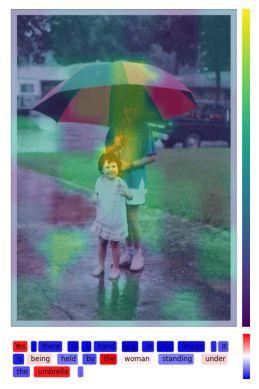

In [ ]:
## Visualization
visualization_mllm(image_path, S_set, saved_json_file, save_path="examples/explanation_qwen25_hallucination_evidence.jpg")
sentence_level_visualization_img = cv2.imread("examples/explanation_qwen25_hallucination_evidence.jpg")
imshow(sentence_level_visualization_img)

## 🛠️ Revise model decision results from the input level

In [25]:
# Select all words to explain
selected_interpretation_token_id = [0]
selected_interpretation_token_word_id = [2753]  # No -> 2753 for QwenVL

## Equip the model with the generated ids and the target token position to be explained
Qwen.generated_ids = generated_ids
Qwen.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])

# Revise the target answering
Qwen.generated_ids = generated_ids[:Qwen.target_token_position.max()]

Qwen.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [26]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [27]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id

  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipykernel_1385712/1304013285.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 54/54 [11:37<00:00, 12.92s/it]


In [ ]:
revised_answering = []

S_set_add = S_set.copy()
S_set_add = np.array([S_set_add[0]-S_set_add[0]] + S_set_add)
image_baseline = cv2.resize(image, (S_set[0].shape[1], S_set[0].shape[0]))

insertion_image = (S_set[0] - S_set[0]) * image_baseline
for smdl_sub_mask in tqdm(S_set):
    insertion_image = insertion_image + smdl_sub_mask * image_baseline
    insertion_image_input = insertion_image.copy().astype(np.float32)
    insertion_image_input = cv2.cvtColor(insertion_image_input, cv2.COLOR_BGR2RGB)
    insertion_image_input = Image.fromarray(np.clip(insertion_image_input, 0, 255).astype(np.uint8))
    
    messages_new = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": insertion_image_input,
                },
                {"type": "text", "text": text_prompt},
            ],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages_new, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages_new)

    # Data proccessing
    inputs = processor(
        text=[text],
        images=image_inputs,    # 这里可以多个
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])
    # Inference: Generation of the output
    with torch.no_grad():
        generated_ids_revised = model.generate(
            **inputs, 
            do_sample=False,      # Disable sampling and use greedy search instead
            num_beams=1,          # Set to 1 to ensure greedy search instead of beam search.
            max_new_tokens=128)
        generated_ids_trimmed_revised = [   # 去掉图像和prompt的文本
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids_revised)
        ]
        
    output_text = processor.batch_decode(
        generated_ids_trimmed_revised, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    revised_answering.append(output_text[0])
    
saved_json_file["revised_answering"] = revised_answering

  0%|          | 0/54 [00:00<?, ?it/s]

/home/cry/anaconda3/envs/qwen/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-06` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 54/54 [01:20<00:00,  1.49s/it]


In [ ]:
def add_value_hallucination(S_set, json_file):
    single_mask = np.zeros_like(S_set[0])
    single_mask = single_mask.astype(np.float16)
    
    value_list_1 = np.array(json_file["smdl_score"])
    value_list_2 = np.array(
        [np.mean(1 - np.array(json_file["org_score"]) + np.array(json_file["baseline_score"]))] + json_file["smdl_score"][:-1]
    )
    
    value_list = value_list_1 - value_list_2
    
    values = []
    value = 0
    i = 0
    for smdl_single_mask, smdl_value in zip(S_set, value_list):
        value = value - abs(smdl_value)
        single_mask[smdl_single_mask==1] = value
        values.append(value)
        i+=1
    attribution_map = single_mask - single_mask.min()
    attribution_map = attribution_map / attribution_map.max()
    
    return 1 - attribution_map, np.array(values)

def gen_cam_hallucination(image_path, mask):
    """
    Generate heatmap
        :param image: [H,W,C]
        :param mask: [H,W],range 0-1
        :return: tuple(cam,heatmap)
    """
    # Read image
    w = mask.shape[1]
    h = mask.shape[0]
    image = cv2.resize(cv2.imread(image_path), (w,h))
    # mask->heatmap
    mask = cv2.resize(mask, (int(w/20),int(h/20)))
    mask = cv2.resize(mask, (w,h))
    heatmap = cv2.applyColorMap(np.uint8(mask), cv2.COLORMAP_COOL)  # cv2.COLORMAP_COOL
    heatmap = np.float32(heatmap)

    # merge heatmap to original image
    cam = 0.5*heatmap + 0.5*np.float32(image)
    return cam.astype(np.uint8), (heatmap).astype(np.uint8)

def norm_image(image):
    """
    Normalization image
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

In [59]:
attribution_map, _ = add_value_hallucination(S_set, saved_json_file)
vis_saliency_map, heatmap = gen_cam_hallucination(image_path, norm_image(attribution_map[:,:,0]))

In [184]:
def visualization(image, S_set, saved_json_file, vis_image, index=None, label_text=None):
    S_set_add = S_set.copy()
    S_set_add = S_set_add[::-1]
    S_set_add = np.array([S_set_add[0]-S_set_add[0]] + S_set_add)
    image_baseline = cv2.resize(image, (S_set[0].shape[1], S_set[0].shape[0]))
    
    revised_answering = saved_json_file["revised_answering"][::-1]
    revised_answering.append("No answer")
    
    org_output = saved_json_file["revised_answering"][-1]

    deletion_ours_images = []

    insertion_image = (S_set_add[0] - S_set_add[0]) * image_baseline
    # insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image_baseline)
    for smdl_sub_mask in S_set_add:
        insertion_image = insertion_image.copy() + smdl_sub_mask * image_baseline
        # insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image_baseline - insertion_image)
        
    curve_score = [saved_json_file["baseline_score"][0]] + saved_json_file["insertion_score"]
    curve_score = curve_score[::-1]

    if index == None:
        ours_best_index = np.argmax(curve_score)
    else:
        ours_best_index = index
    x = [0.0] + saved_json_file["region_area"]  # bug
    x = (1 - np.array(x)).tolist()[::-1]
    i = len(x)

    # fig, [ax1, ax2, ax3] = plt.subplots(1,3, gridspec_kw = {'width_ratios':[2, 2, 1.5]}, figsize=(30,8))
    # fig.subplots_adjust(wspace=0.4)  # 增加wspace值，增加图2和图3之间的间隔
    fig = plt.figure(figsize=(30, 8))
    
    ax1 = fig.add_axes([0.05, 0.1, 0.3, 0.8])  # 图1位置
    ax2 = fig.add_axes([0.37, 0.1, 0.3, 0.8])  # 图2位置
    ax3 = fig.add_axes([0.75, 0.1, 0.25, 0.8])
    
    ax1.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.xaxis.set_visible(True)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Attribution Map', fontsize=54, pad=30)
    ax1.set_facecolor('white')
    
    hallucination_aws = r"$\bf{Hallucinated \ response:}$" + "\n" + "\n".join(textwrap.wrap(org_output, width=45))
    wrapped = "\n".join(textwrap.wrap(revised_answering[ours_best_index], width=45))
    final_label = hallucination_aws + "\n" + r"$\bf{Revised\ answer:}$" + "\n" + wrapped
    ax1.set_xlabel(final_label, fontsize=44, ha='left')
    ax1.xaxis.set_label_coords(0, -0.05)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax1.imshow(vis_image[...,::-1].astype(np.uint8))
    
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(True)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Hallucination Mitigation', fontsize=54, pad=30)
    ax2.set_facecolor('white')
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1))
    yticks = ax3.get_yticks()
    yticks = yticks[yticks != 0]
    ax3.set_yticks(yticks)
    
    ax3.set_ylabel('Corrected Score', fontsize=44)
    ax3.set_xlabel('Remove Biased Region', fontsize=44)

    ax3.tick_params(axis='both', which='major', labelsize=40)

    curve_color = "#FF4500"
    # curve_color = "#1E90FF"

    x_ = x[:i]
    ours_y = curve_score[:i]
    ax3.plot(x_, ours_y, color=curve_color, linewidth=3.5)  # draw curve
    ax3.set_facecolor('white')
    ax3.spines['bottom'].set_color('black')
    ax3.spines['bottom'].set_linewidth(2.0)
    ax3.spines['top'].set_color('none')
    ax3.spines['left'].set_color('black')
    ax3.spines['left'].set_linewidth(2.0)
    ax3.spines['right'].set_color('none')

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    ax3.scatter(x_[-1], ours_y[-1], color=curve_color, s=54)  # Plot latest point
    # 在曲线下方填充淡蓝色
    ax3.fill_between(x_, ours_y, color=curve_color, alpha=0.1)

    kernel = np.ones((10, 10), dtype=np.uint8)
    # ax3.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线
    ax3.axvline(x=x_[ours_best_index], color='red', linewidth=3.5)  # 绘制红色垂直线
    ax3.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    mask = 1-(S_set_add.sum(0) - S_set_add[:ours_best_index+1].sum(0)).sum(-1).astype('uint8')

    if ours_best_index != 0:
        dilate = cv2.dilate(mask, kernel, 3)
        edge = dilate - mask

    image_debug = image_baseline.copy()
    image_debug[mask>0] = image_debug[mask>0] * 0.3
    if ours_best_index != 0:
        image_debug[edge>0] = np.array([0,0,255])
    
    image_debug = cv2.resize(image_debug, (image.shape[1],image.shape[0]))
    ax2.imshow(image_debug[...,::-1])
    
    # auc = metrics.auc(x, curve_score)
    ax3.set_title('Corrected Target Score', fontsize=54, pad=30)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

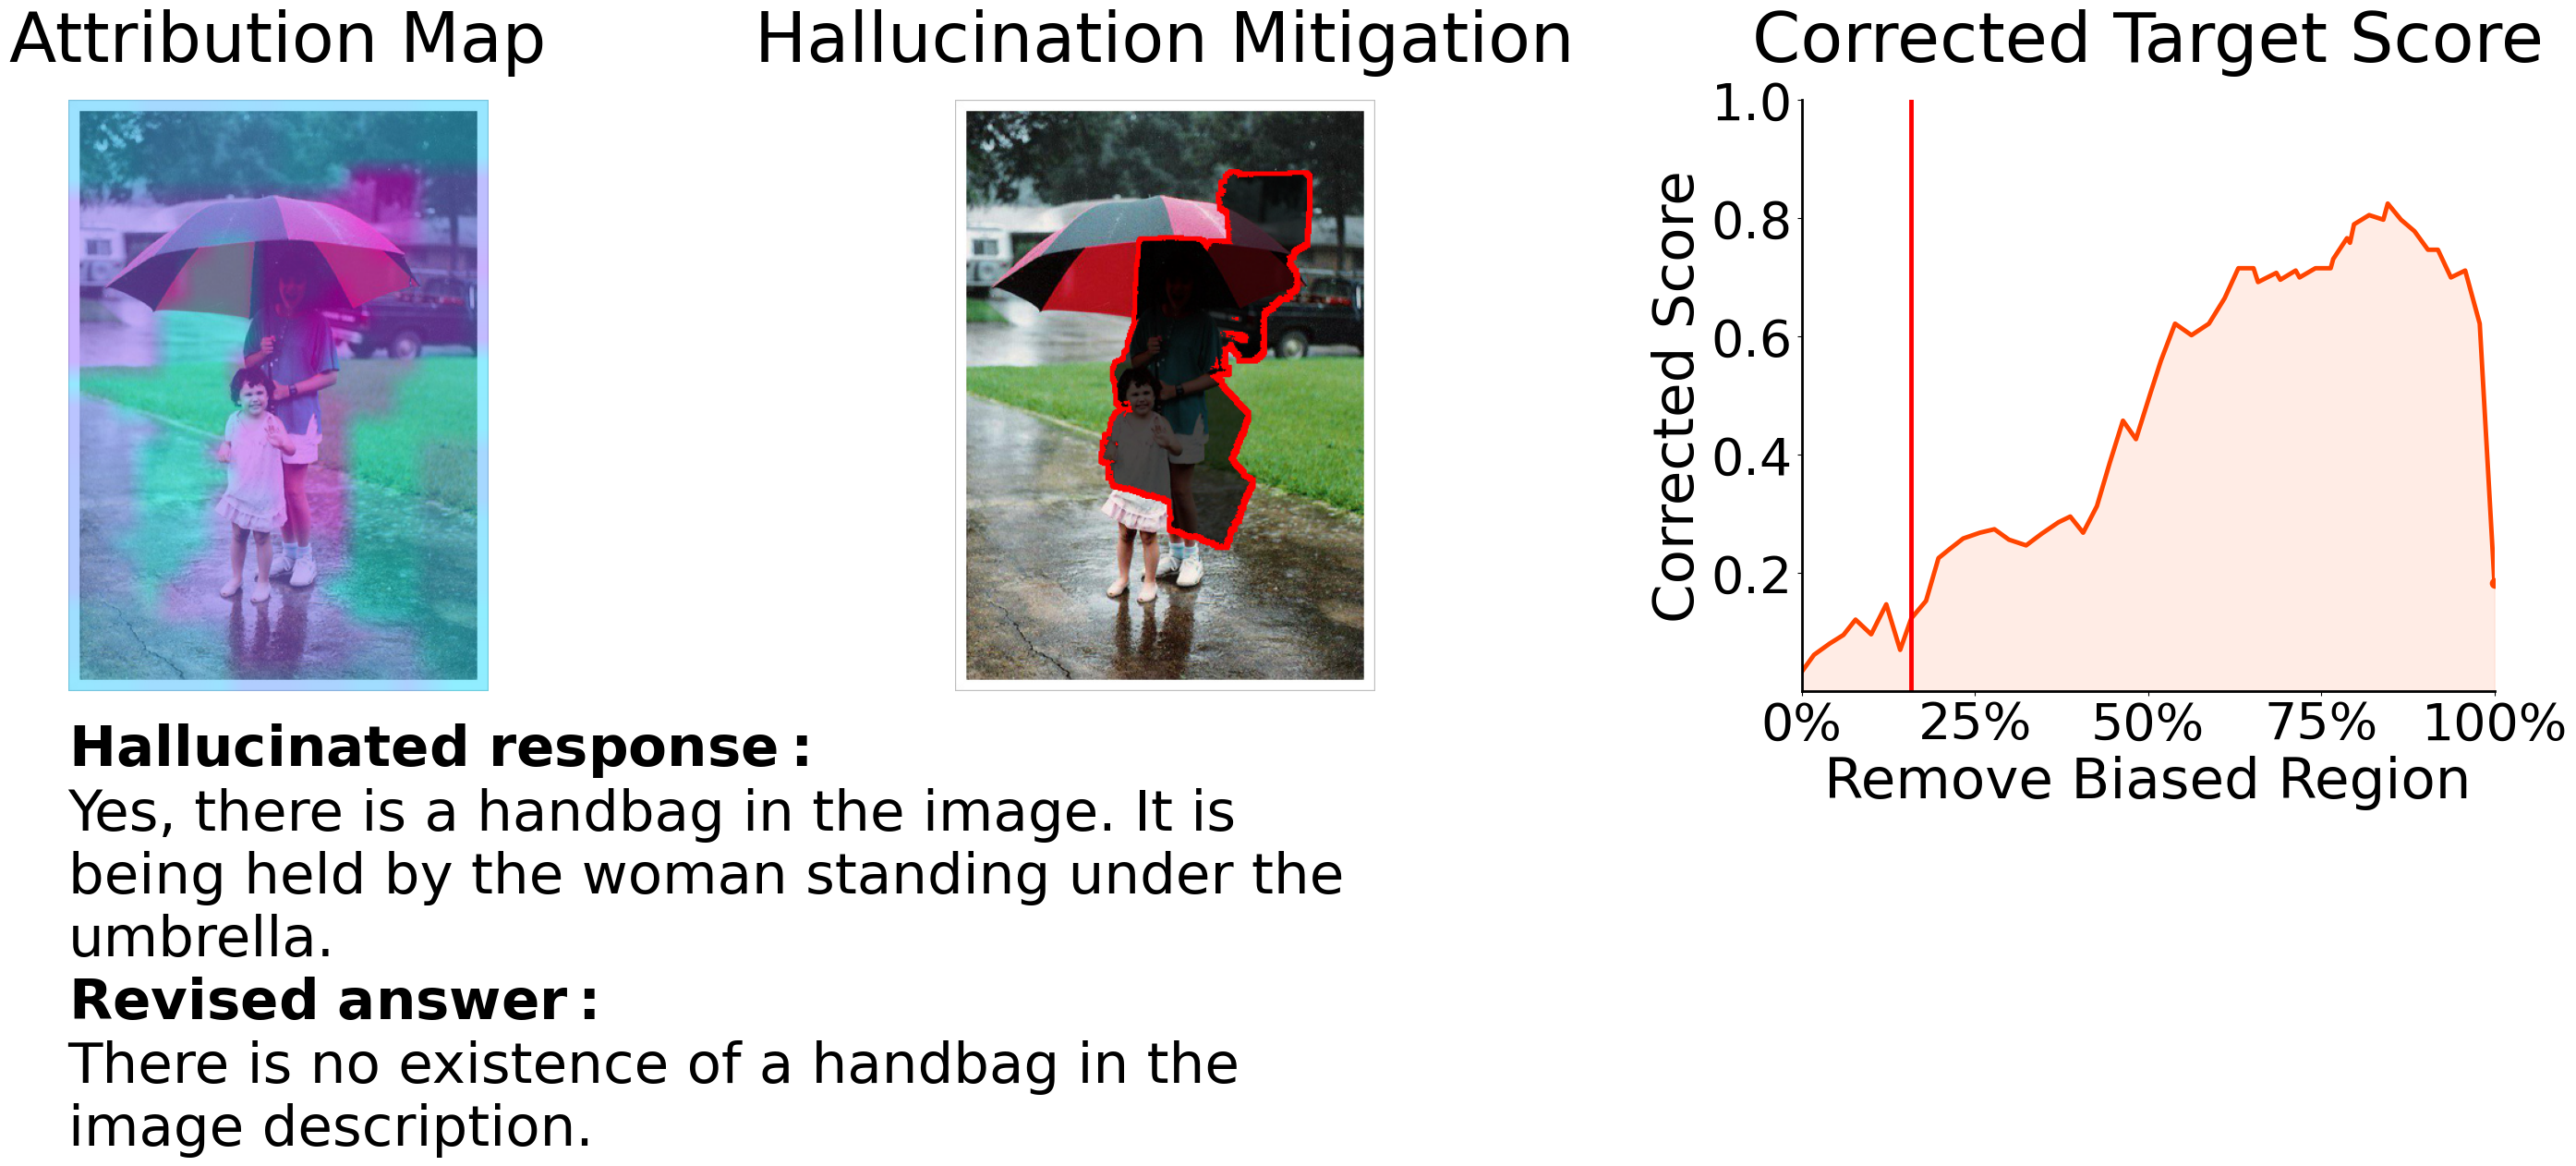

In [185]:
visualization(image, S_set, saved_json_file, vis_saliency_map,8)